<a href="https://colab.research.google.com/github/akshaypt7/amazon_sales_prediction/blob/main/my_project_01_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This is part 2 of the project. Here we make improvements that we have learnt from part 1 of the project.

#### Improvements 

- One of the mistakes we have done in the first part was that there was data leakage. 

  - **When the sales are made for each asins in a day, we are not considering the asins that were not sold that day. so the thing is we need to add ASINS even when there was no sale made for that. We can give the quantity as 0. **


How do we do this?

When we read data for each month, we see which are the unique ASINs, then these asins should be added to each days in that month, even for the days when these asins are not sold. 

one another thing to note is we can even look at working this for the enitre dataframe at once, rather than going month by month. The reason is what if for one month the product was laucnhed but on second month there was no sales, even though that product was available. this means that for all those we wont even mention the asin, but on the third month we mention it again.

But finally we have decided to add the asins based on months. Since during months if the products were out of stock it is better to not to show the asin rather than showing the sold quantities as zero

- we can change the continous and categorical variables that we have defined.

- One another mistake that we had done in part 1 was that we had only taken 679 data points as the validation set, we have used 10,500 as the train set. we should have atleast taken 3000 units as validation set.

  This was the reason we had high training error and less validation error. This makes sense why we also had high OOB_error and less validation error, as oob_error is calculated with atleast 30% data.

- Also we will sum up all the orders placed for one product in a single day. This gives a structure to the dataset, and also a format like this can be used to realtime predictions.

  

- Next thing we learnt is we need to understand what metric we have to use.

- We can use both classification and regression. When we use both then we need to understand what has to be used as the metric. This assumption was wrong, we cannot use classification since the quanities can varry btw 0-41. We had thought of this assumpltion when we were working of the first version of the project. Now it does not apply.

- we have to create a baseline model which predicts the majority class for all the data points.

- Learn more about metrics. We have decided to use MAE, since this goes well with inventory prediction.

- One another thing what we can note is, we should be able to change the threshold. We have to able to convert the predictions for example, from 1.4 to 2, if we are going with regression. Here we need to come up with something like np.where(). We can see what is the performance at different thresholds.

- We will be adding one more that is price for each product. We also have Invoice amount, which is the price at which the product is sold (coupons).
  - This is done because Invoice is the sum of all the orders placed, maybe the customer made two purchases of same product. Where as price is constant.


### Importing Libraries

In [ ]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 29.9 MB/s 
     |████████████████████████████████| 60 kB 9.6 MB/s 
     |████████████████████████████████| 188 kB 53.5 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 1.2 MB 52.2 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 51 kB 326 kB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
# from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
import pandas as pd

### Getting all the csv & excel files from the folder.

In [ ]:
import os
files = os.listdir('/content/gdrive/MyDrive/my_project_01')


In [ ]:
dict_files = {}
for i,file in enumerate(files):
  try:
    # dict_files[i] = pd.read_csv( '/content/drive/MyDrive/my_project_01/' +str(file),low_memory=False)
    dict_files[i] = pd.read_csv( '/content/gdrive/MyDrive/my_project_01/' +str(file),low_memory=False)
  except:
    # dict_files[i] = pd.read_excel( '/content/drive/MyDrive/my_project_01/' +str(file))
    if files[i] == '.ipynb_checkpoints':
      continue
    dict_files[i] = pd.read_excel( '/content/gdrive/MyDrive/my_project_01/' +str(file))


We have to take in Invoice Amount instead of Principal amount (since it helps to sepearate canceled and refund orders)

#### Creating Dataframes

In [ ]:
df_dicts = {}

for i in range(len(dict_files)):
  df_dicts[i] = dict_files[i][['Order Date','Quantity','Asin','Invoice Amount','Item Promo Discount']]


#### Trying the Data processing on 1 month

We will then apply this on all months.

In [ ]:
df_new = df_dicts[2]
df_new_1 = df_new.copy()

In [ ]:
df_new_1['date'] = df_new['Order Date'].dt.date

In [ ]:
df_new  = df_new_1.drop(['Order Date'],axis=1)

In [ ]:
asin_list = df_new.Asin.unique()
asin_list

array(['B07TM3LRVB', 'B0849NLNTQ', 'B08332221J', 'B07MK32L49', 'B08976V1BZ', 'B0859193NJ', 'B07TJ1HDTM', 'B0858X26QM', 'B07KYFHTGF', 'B0859B5J8T', 'B0897LPBHR', 'B084JJWJ31', 'B07W1YYQ9G',
       'B07ZBCTB9N', 'B07S8NC532', 'B07YC69QKT', 'B07Z7QX6ST'], dtype=object)

In [ ]:
df_new['date'] = pd.to_datetime(df_new['date'])

In [ ]:
# Removing refund and return
cond = df_new['Invoice Amount'] > 0

df_new_2  = df_new.where(cond)
df_new_2.dropna(how='all',inplace = True)

In [ ]:
max_date = max(df_new_2['date']) 
min_date = (min(df_new_2['date']))

In [ ]:
# finding all the dates btw max and min

date_list  = pd.date_range(min_date,max_date)

In [ ]:
df_asin = pd.DataFrame(columns = ['date', 'Asin'])

In [ ]:
# Creating the dataframe - ASINs , for days no sales have made
index = 0
while True:

  for date in (date_list) :
    for asin in (asin_list):
      df_asin.loc[index] = [date,asin]
      index = index + 1

  break    

In [ ]:
df_asin.head()

,date,Asin
0,2020-12-31,B07TM3LRVB
1,2020-12-31,B0849NLNTQ
2,2020-12-31,B08332221J
3,2020-12-31,B07MK32L49
4,2020-12-31,B08976V1BZ


In [ ]:
df_new = df_new_2

In [ ]:
# Merging the datasets, so we have the details for all Asins for each day
df_merge = df_new.merge(df_asin, how='outer', on=['date','Asin'])
df_merge

,Quantity,Asin,Invoice Amount,Item Promo Discount,date
0,1.0,B07TM3LRVB,1135.0,0.0,2020-12-31
1,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
2,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
3,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
4,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
...,...,...,...,...,...
810,NaN,B084JJWJ31,NaN,NaN,2021-01-28
811,NaN,B07KYFHTGF,NaN,NaN,2021-01-29
812,NaN,B08976V1BZ,NaN,NaN,2021-01-29
813,NaN,B08332221J,NaN,NaN,2021-01-29


In [ ]:
df_merge = df_new.merge(df_asin, how='outer', on=['date','Asin'])
df_merge

,Quantity,Asin,Invoice Amount,Item Promo Discount,date
0,1.0,B07TM3LRVB,1135.0,0.0,2020-12-31
1,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
2,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
3,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
4,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
...,...,...,...,...,...
1101,NaN,B07W1YYQ9G,NaN,NaN,2021-01-31
1102,NaN,B07ZBCTB9N,NaN,NaN,2021-01-31
1103,NaN,B07S8NC532,NaN,NaN,2021-01-31
1104,NaN,B07YC69QKT,NaN,NaN,2021-01-31


In [ ]:
# Calculating the price for each product
df_merge['price'] = df_merge['Invoice Amount']/df_merge['Quantity']

In [ ]:
# Filling NA with 0 for quantities
df_merge['Quantity'] = df_merge['Quantity'].fillna(0)

In [ ]:
# This will be zero for missing values since the sales have not been made for missing values.
df_merge['Invoice Amount'] = df_merge['Invoice Amount'].fillna(0)

In [ ]:
# This will be zero for missing values since the sales have not been made for missing values.
df_merge['Item Promo Discount'] = df_merge['Item Promo Discount'].fillna(0)

In [ ]:
df_merge.head()

,Quantity,Asin,Invoice Amount,Item Promo Discount,date,price
0,1.0,B07TM3LRVB,1135.0,0.0,2020-12-31,1135.0
1,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01,1135.0
2,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01,1135.0
3,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01,1135.0
4,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01,1135.0


In [ ]:
# Finding the mode value for prices of each product, we can use that to as the price value for each asins(NA).
df_price = df_merge.groupby('Asin')['price'].agg(lambda x: np.mean(pd.Series.mode(x))).reset_index()

In [ ]:
df = df_merge.set_index('Asin')

In [ ]:
df_price = df_price.set_index('Asin')

In [ ]:
df.update(df_price,overwrite = False, join = 'left')

In [ ]:
# df = df_merge.update(df_price, overwrite = False, join = 'left')

In [ ]:
df.reset_index(inplace = True)

In [ ]:
x = df.groupby(['date','Asin','Item Promo Discount','price']).sum()
x

Quantity  Invoice Amount
date       Asin       Item Promo Discount price                             
2020-12-31 B07KYFHTGF 0.0                 1995.000       0.0             0.0
           B07MK32L49 0.0                 149.000        0.0             0.0
           B07S8NC532 0.0                 2099.000       0.0             0.0
           B07TJ1HDTM 0.0                 1649.000       0.0             0.0
           B07TM3LRVB 0.0                 1135.000       1.0          1135.0
...                                                      ...             ...
2021-01-31 B0858X26QM 0.0                 599.000        0.0             0.0
           B0859193NJ 0.0                 599.000        0.0             0.0
           B0859B5J8T 0.0                 499.000        1.0           499.0
           B08976V1BZ 0.0                 1599.000       0.0             0.0
           B0897LPBHR 0.0                 1896.375       0.0             0.0

[618 rows x 2 columns]

In [ ]:
x.reset_index()

,date,Asin,Item Promo Discount,price,Quantity,Invoice Amount
0,2020-12-31,B07KYFHTGF,0.0,1995.000,0.0,0.0
1,2020-12-31,B07MK32L49,0.0,149.000,0.0,0.0
2,2020-12-31,B07S8NC532,0.0,2099.000,0.0,0.0
3,2020-12-31,B07TJ1HDTM,0.0,1649.000,0.0,0.0
4,2020-12-31,B07TM3LRVB,0.0,1135.000,1.0,1135.0
...,...,...,...,...,...,...
613,2021-01-31,B0858X26QM,0.0,599.000,0.0,0.0
614,2021-01-31,B0859193NJ,0.0,599.000,0.0,0.0
615,2021-01-31,B0859B5J8T,0.0,499.000,1.0,499.0
616,2021-01-31,B08976V1BZ,0.0,1599.000,0.0,0.0


In [ ]:
x.loc['2021-01-31']

Quantity  Invoice Amount
date       Asin       Item Promo Discount price                             
2021-01-31 B07KYFHTGF  0.00               1995.000       0.0            0.00
           B07MK32L49  0.00               149.000        0.0            0.00
           B07S8NC532  0.00               2099.000       0.0            0.00
           B07TJ1HDTM  0.00               1649.000       0.0            0.00
           B07TM3LRVB -56.75              1078.250       6.0         6469.50
                       0.00               1135.000      12.0        13620.00
           B07W1YYQ9G  0.00               399.000        0.0            0.00
           B07YC69QKT  0.00               1649.000       0.0            0.00
           B07Z7QX6ST  0.00               486.525        0.0            0.00
           B07ZBCTB9N  0.00               1135.000       0.0            0.00
           B08332221J -74.95              1424.050       1.0         1424.05
           B0849NLNTQ  0.00               1599.000       2.0         3198.00
           B084JJWJ31  0.00               599.000        0.0            0.00
           B0858X26QM  0.00               599.000        0.0            0.00
           B0859193NJ  0.00               599.000        0.0            0.00
           B0859B5J8T  0.00               499.000        1.0          499.00
           B08976V1BZ  0.00               1599.000       0.0            0.00
           B0897LPBHR  0.00               1896.375       0.0            0.00

### Processing all the data

In [ ]:
# concat all df
def process_data(df_dicts):

  df_main = pd.DataFrame()


  for i in range(len(df_dicts)):
  # we need to convert the Order date column into date_time
  # if df_dicts[i]['Order Date'].dtype != 'datetime64[ns]' :
    df_copy = df_dicts[i].copy()

    df_copy['Order Date'] = pd.to_datetime(df_dicts[i]['Order Date'])

    # adding new columns
    df_copy['date'] = df_copy['Order Date'].dt.date #
    df_copy['hour'] = df_copy['Order Date'].dt.hour

    # print(df_copy.hour.nunique())

    df_dicts[i] = df_copy.drop(['Order Date'],axis=1) 

    # Creating dataframe for all unique asins in one month
    asin_list = df_dicts[i].Asin.unique()

    # Removing refund and return
    cond = df_dicts[i]['Invoice Amount'] > 0

    df_copy_2  = df_dicts[i].where(cond)
    df_copy_2.dropna(how='all',inplace = True) # Removing all transactions that are either refund or return

    max_date = max(df_copy_2['date']) 
    min_date = (min(df_copy_2['date']))
    date_list  = pd.date_range(min_date,max_date)


    # Creating Asin Dataframe
    df_asin = pd.DataFrame(columns = ['date', 'Asin'])
    index = 0
    while True:

        for date in (date_list) :
          for asin in (asin_list):
            df_asin.loc[index] = [date,asin]
            ndex = index + 1

        break    
    df_copy_2['date'] = pd.to_datetime(df_copy_2['date'])  

    df_dicts[i] = df_copy_2


    # Merging the dataframes
    df_merge = df_copy_2.merge(df_asin, how='outer', on=['date','Asin'])

    # print(df_merge.hour.nunique())
    
    
    # Creating new columns
    df_merge['price'] = df_merge['Invoice Amount']/df_merge['Quantity']
    df_merge['Quantity'] = df_merge['Quantity'].fillna(0)
    df_merge['Invoice Amount'] = df_merge['Invoice Amount'].fillna(0)
    df_merge['Item Promo Discount'] = df_merge['Item Promo Discount'].fillna(0)

    # Filling missing values in df_price
    df_price = df_merge.groupby('Asin')['price'].agg(lambda x: np.mean(pd.Series.mode(x))).reset_index()

    df = df_merge.set_index('Asin')
    df_price = df_price.set_index('Asin')

    df.update(df_price,overwrite = False, join = 'left')
    # print(df.hour.nunique())

    df = df.groupby(['date','Asin','Item Promo Discount','price','hour']).sum()
    df.reset_index(inplace=True)

    df_main = pd.concat([df_main , df])
    # print(df_main.hour.nunique())
  
  return df_main    


In [ ]:
df_main = process_data(df_dicts)


In [ ]:
# save_pickle('/content/gdrive/MyDrive/bluebook/df_main.pkl',df_main)

#### Loading the saved dataframe

In [ ]:
df_main = load_pickle('/content/gdrive/MyDrive/bluebook/df_main.pkl')

### Setting up train and validation data

In [ ]:
df_main = add_datepart(df_main , 'date') # Adding date details

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
dep_var = 'Quantity'

In [ ]:
cont, cat = cont_cat_split( df_main,1,dep_var= dep_var)

In [ ]:
# SPLITS 
condition = (df_main.Year < 2020) | (df_main.Month < 8)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

In [ ]:
len(train_idx), len(valid_idx)

(7517, 3429)

In [ ]:
splits = (list(train_idx),list(valid_idx))

#### Creating Tabular Pandas

In [ ]:
to = TabularPandas(df_main, procs= procs,cat_names= cat, cont_names=cont, splits= splits,y_names=dep_var)

In [ ]:
to.show(3)

,Asin,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Item Promo Discount,price,hour,Invoice Amount,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,Quantity
0,B07KYFHTGF,False,False,False,False,False,False,0.000000,1995.000000,12.0,1995.000000,2021,1,1,4,0,4,1.609718e+09,1.0
1,B07TM3LRVB,False,False,False,False,False,False,-56.750000,1078.250000,20.0,1078.250000,2021,1,1,8,4,8,1.610064e+09,1.0
2,B08976V1BZ,False,False,False,False,False,False,-79.949997,1519.050049,22.0,1519.050049,2021,1,1,9,5,9,1.610150e+09,1.0


#### Creating Train and Test set

In [ ]:
x_train,y_train = to.train.xs, to.train.y
x_valid, y_valid = to.valid.xs, to.valid.y

### Base Line Model


Base line model will predict the most frequent y variable (which is 1)

In [ ]:
y_train.value_counts()

1.0     6330
2.0      978
3.0      161
4.0       36
5.0        7
7.0        2
39.0       1
9.0        1
6.0        1
Name: Quantity, dtype: int64

In [ ]:

base_y = [1]*len(y_valid)
base_y = np.array(base_y)

#### Mean Absolute Error & RMSE of Baseline model

The baseline prediction error is 0.226 using **MAE**

In [ ]:
from sklearn.metrics import mean_absolute_error as mae


In [ ]:
mae(y_valid,base_y)

0.226305045202683

RMSE

In [ ]:

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
y_valid

0      1.0
159    1.0
160    1.0
161    1.0
162    3.0
      ... 
198    5.0
199    1.0
200    1.0
201    1.0
202    0.0
Name: Quantity, Length: 2195, dtype: float32

In [ ]:
base_y

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_actual,y_predicted):
  return mean_squared_error(y_actual, y_predicted, squared=False)

In [ ]:
rmse(y_valid.values,base_y)

0.5964803934127824

### Random forest

In [ ]:
def rf(xs, y, n_estimators=40,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
         max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
rf =rf(x_train,y_train)

In [ ]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)>

#### Mean Root Square Error

In [ ]:

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(rf,x_train,y_train), m_rmse(rf,x_valid,y_valid)

(0.373049, 0.094752)

In [ ]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((7517, 18), (7517,), (3429, 18), (3429,))

#####We need to think about someother metric to use other than this, which is more accurate to the problem at hand. 

#### Using Mean Absolute Error

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
mae(y_valid,rf.predict(x_valid))

0.028076104794112888

In [ ]:
mae(y_train,rf.predict(x_train))

0.020305458216946435

***The Random Forest model is better than the baseline model.***

##### Creating our own function to change threshold.

In [ ]:
# This functions helps to convert the value into integ
def pred(y_pred,thres= 0.5):
  new_pred = np.where((y_pred-int(y_pred)) < thres,int(y_pred), int(y_pred)+1)
  return new_pred

In [ ]:
new_pred = np.vectorize(pred) # So that the function will accept list of integers.

***Random forest prediction, with a threshold of 0.42 gives the best results. The result is better than the baseline model error of 0.226.***

We were able to improve the performance of the model again.

In [ ]:
mae(y_valid,(new_pred(rf.predict(x_valid),0.42)))



0.005540974044911053

#### Predictions based on number of trees

In [ ]:
preds = np.stack([t.predict(x_valid) for t in rf.estimators_])

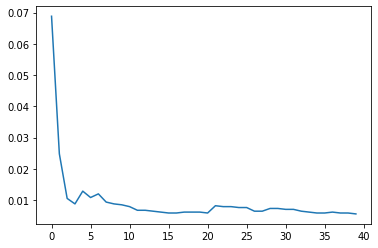

In [ ]:
plt.plot([mae(new_pred(preds[:i+1].mean(0),0.42), y_valid) for i in range(40)]);

### Feature Importances

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(rf, x_train)
fi[:10]

,cols,imp
10,Invoice Amount,0.817458
8,price,0.101535
0,Asin,0.028686
17,Elapsed,0.011727
16,Dayofyear,0.011217
14,Day,0.010034
9,hour,0.006583
15,Dayofweek,0.003802
13,Week,0.003509
7,Item Promo Discount,0.003053


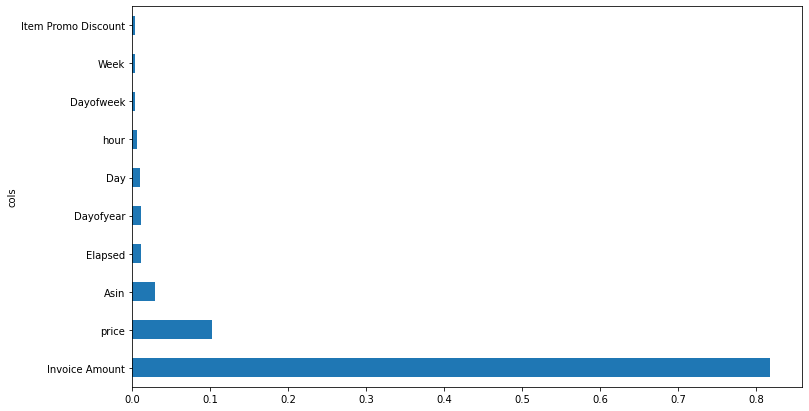

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10]);

### Redundant Features

We can observe that only few columns are highly dependent, like Dayodyear and Month.

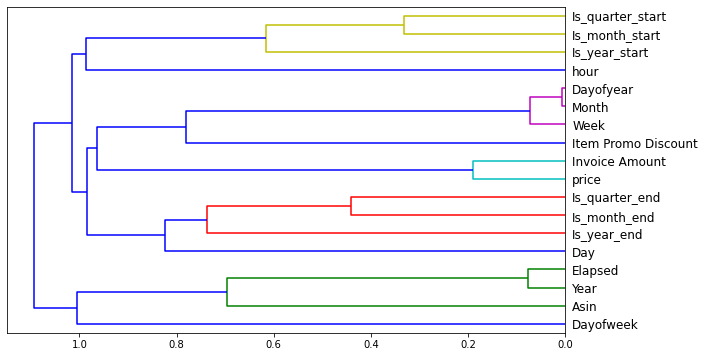

In [ ]:
cluster_columns(x_train)

Day of year and Month features are highly correlated. We can remove one feature and get the same performance.

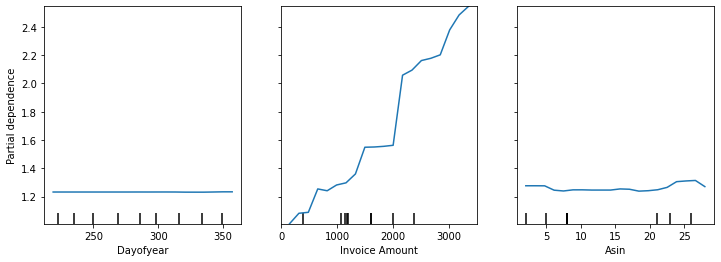

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(rf, x_valid, ['Dayofyear','Invoice Amount','Asin'],
                        grid_resolution=20, ax=ax);

### Tree Intrepter


In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
row = x_valid.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(rf, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([1.06099432]), 1.2006219236397504, -0.13962760545793174)

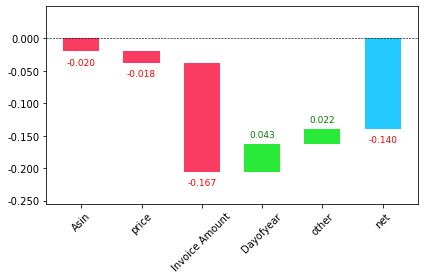

In [ ]:
waterfall(x_valid.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Creating a Neural network

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_main, max_card=9000, dep_var=dep_var)

In [ ]:
df_main[cat_nn].nunique()

Asin                 46
Year                  3
Month                12
Week                 53
Day                  31
Dayofweek             7
Dayofyear           366
Is_month_end          2
Is_month_start        2
Is_quarter_end        2
Is_quarter_start      2
Is_year_end           2
Is_year_start         2
dtype: int64

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_main, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(528)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

(1.0, 39.0)

Creating the learner and using MAE as the metric.

In [ ]:
learn = tabular_learner(dls, y_range=(0,42), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss, metrics= torch.nn.L1Loss)

SuggestedLRs(valley=0.001737800776027143)

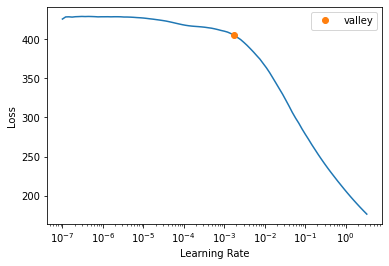

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,None,time
0,372.822235,379.405029,19.417332,00:00
1,303.498322,432.771057,20.098303,00:00
2,254.218079,345.267303,17.397095,00:00
3,219.247574,197.446472,11.554172,00:00
4,196.244095,154.227966,8.943225,00:00


In [ ]:
# Using weight Decay
learn = tabular_learner(dls, y_range=(0,42), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss, metrics= torch.nn.L1Loss)
learn.fit_one_cycle(7, 1e-3,wd=0.1)

epoch,train_loss,valid_loss,None,time
0,415.050323,368.318848,19.181446,00:00
1,391.548187,301.503632,16.527311,00:00
2,323.645782,250.139923,13.706243,00:00
3,266.135895,166.949661,9.263852,00:00
4,224.753204,141.152115,6.903642,00:00
5,197.286102,139.188156,6.743922,00:00
6,177.649429,136.893204,6.467886,00:00


Using Weight Decay we were able to improve the performance of the Neural network. 

But here the random forest has performed better than the neural network.

The Mean Absolute score for the 

- Neural Network is 6.46

- Random Forest is 0.028

- Random Forest with threshold of 4.2 = 0.005

- & Base line model is  0.226 